<h1><center>DL Project (Food Recognition)</center></h1>
<center>Students should develop a software system aimed at recognising and segmenting food items in each image.</center>
<br>

<h3><center>Gee Jun Hui Leonidas Yunani<br>Marini Luca</center></h3>
<br>

<center>leonidas.gee@studio.unibo.it<br>luca.marini9@studio.unibo.it</center>
<br>

<center>Academic Year: 2020 / 2021</center>

In [1]:
# Install the necessary libraries
!pip install pycocotools
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272259 sha256=0f6b8adea703800297ceaebb595e77615f0ec2b7ef929a51fb8e8000096058a5
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools
     |████████████████████████████████| 50 kB 1.2 MB/s 
env: SM_FRAMEWORK=tf.keras


In [2]:
# Import the necessary libraries
from pycocotools.coco import COCO
import os
import random
import cv2
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
# Utilised functions
def getCOCO(anns_path):
    
    # Initialise the COCO api object
    coco = COCO(anns_path)
    
    # Load the categories
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print the number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

def getMask(image_id, coco, classes, image_size):
    
    # Create a zero array with the given size and number of classes
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        
        # Get the binary mask for the annotation
        binary = cv2.resize(coco.annToMask(ann), image_size, interpolation=cv2.INTER_AREA)

        # Get the channel index for the annotation
        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        # Update the channel of the annotation
        mask[:, :, channel] = binary

        # Update the background channel of the annotation
        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

def getGenerator(path, coco, classes, image_size, batch_size, augment=False):
    
    # Initialise the current count and image list
    c = 0
    n = os.listdir(path)
    random.shuffle(n)
    
    # Initialise the augmentator object if required
    if augment == True:
        geo_aug = iaa.Fliplr(1.0)
    
    while (True):
        
        # Create the initial image and mask batches
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            
            # Read the image from the image folder
            img = cv2.imread(path + '/' + n[i])
            
            # Resize the image according to the given image size
            img =  cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
            
            # Convert the image from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Get the multi-channel mask
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            # Apply augmentations if required
            if augment == True:
                if random.random() < 0.5:
                    img = geo_aug(image=img)
                    mask = geo_aug(image=mask)            
            
            # Add the image and mask to the image and mask batches
            img_batch[i-c] = img
            mask_batch[i-c] = mask
        
        # If current count exceeds the total images, reset to 0 and shuffle image list
        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch
        
def visualiseSamples(path, coco, classes, image_size, batch_size, augment=False):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size, augment)
    images, masks = next(temp_gen)
    
    for i in range(batch_size):
        plt.figure(figsize=(8, 16))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        
        true_mask = masks[i]
        for c in range(274):
            true_mask[:, :, c] = true_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(true_mask, axis=2))
        plt.axis('off')
        
        plt.show()
        
def showPredictions(generator, model):
    images, masks = next(generator)
    prediction = model.predict(images)
    
    for i in range(5):
        plt.figure(figsize=(10, 16))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        
        full_mask = masks[i]
        for c in range(274):
            full_mask[:, :, c] = full_mask[:, :, c] * (c+1)
            
        plt.imshow(np.max(full_mask, axis=2))
        plt.axis('off')
        
        pred_mask = np.round(prediction[i])
        for c in range(274):
            pred_mask[:, :, c] = pred_mask[:, :, c] * (c+1)
            
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.max(pred_mask, axis=2))
        plt.axis('off')
        
        plt.show()

# Data Preparation

In [4]:
# Set the hyperparameters
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300
EPOCHS = 10

In [5]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-images/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-images/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-images/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-images/val-v0.4/val/annotations.json'

In [6]:
# Load the annotations of the image dataset
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)

loading annotations into memory...
Done (t=3.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [7]:
# Get the training and validation generators
train_gen = getGenerator(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, BATCH_SIZE, True)
train_length = len(os.listdir(train_imgs_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_imgs_path, val_coco, val_classes, IMAGE_SIZE, BATCH_SIZE)
val_length = len(os.listdir(val_imgs_path))
print('Number of validation images: {}'.format(val_length))

Number of training images: 24119
Number of validation images: 1269


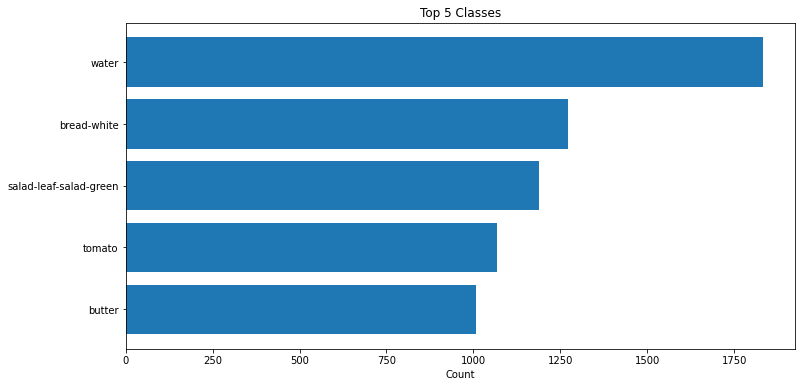

In [8]:
# Show the top 5 training classes by count
plt.figure(figsize=(12, 6))

top_5 = train_classes.sort_values(by=['Count'], ascending=False)[:5]
top_5_keys = list(top_5.Category)
top_5_values = list(top_5.Count)

top_5_keys.reverse()
top_5_values.reverse()
plt.barh(top_5_keys, top_5_values)
plt.title('Top 5 Classes')
plt.xlabel('Count')

plt.show()

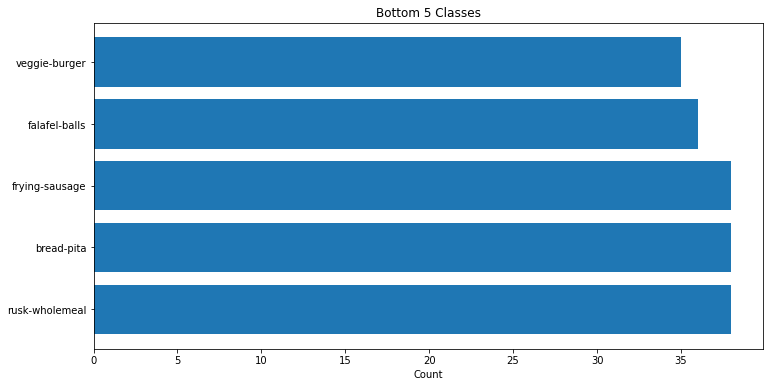

In [9]:
# Show the bottom 5 training classes by count
plt.figure(figsize=(12, 6))

bottom_5 = train_classes.sort_values(by=['Count'], ascending=True)[:5]
bottom_5_keys = list(bottom_5.Category)
bottom_5_values = list(bottom_5.Count)

bottom_5_keys.reverse()
bottom_5_values.reverse()
plt.barh(bottom_5_keys, bottom_5_values)
plt.title('Bottom 5 Classes')
plt.xlabel('Count')

plt.show()

/opt/conda/lib/python3.7/site-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (48, 48, 274) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


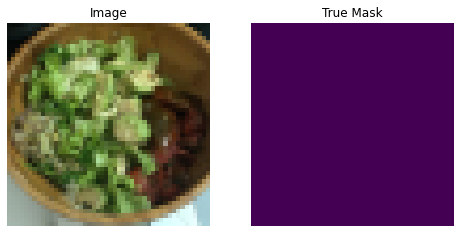

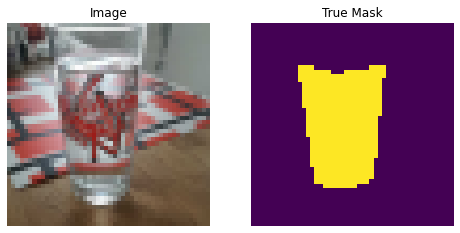

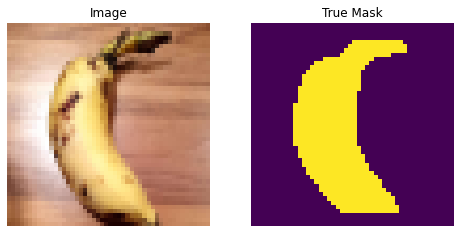

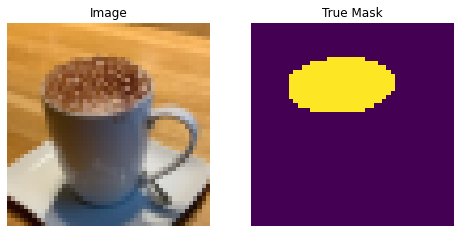

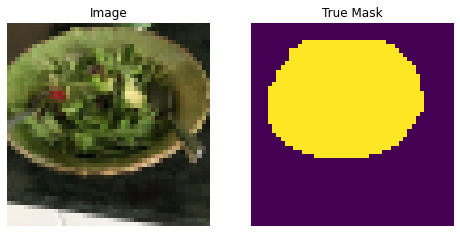

In [10]:
# Visualise sample images with their backgrounds and objects
visualiseSamples(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, 5, augment=True)

# Semantic Segmentation

In [11]:
# Define the model to be trained
model = sm.PSPNet('efficientnetb7', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])

2021-11-05 11:24:16.307853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:24:16.424863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:24:16.426058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 11:24:16.427845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

258449408/258434480 [==============================] - 2s 0us/step


In [12]:
# Train the defined model on the dataset
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=EPOCHS)

# Save the model weights to the output
model.save_weights('weights.h5')

2021-11-05 11:24:50.075656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-05 11:25:00.371991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


80/80 [==============================] - 832s 10s/step - loss: 0.9827 - iou_score: 0.0156 - precision: 0.0307 - recall: 0.3901 - val_loss: 1.0109 - val_iou_score: 0.0052 - val_precision: 0.0326 - val_recall: 0.3687
Epoch 2/10
80/80 [==============================] - 635s 8s/step - loss: 0.9534 - iou_score: 0.0359 - precision: 0.0777 - recall: 0.4189 - val_loss: 0.9819 - val_iou_score: 0.0211 - val_precision: 0.0861 - val_recall: 0.4080
Epoch 3/10
80/80 [==============================] - 644s 8s/step - loss: 0.9051 - iou_score: 0.0816 - precision: 0.1739 - recall: 0.4283 - val_loss: 0.8517 - val_iou_score: 0.1444 - val_precision: 0.3442 - val_recall: 0.3982
Epoch 4/10
80/80 [==============================] - 617s 8s/step - loss: 0.7149 - iou_score: 0.2758 - precision: 0.5923 - recall: 0.4280 - val_loss: 0.7233 - val_iou_score: 0.2750 - val_precision: 0.6374 - val_recall: 0.4072
Epoch 5/10
80/80 [==============================] - 603s 8s/step - loss: 0.6767 - iou_score: 0.3116 - precisio

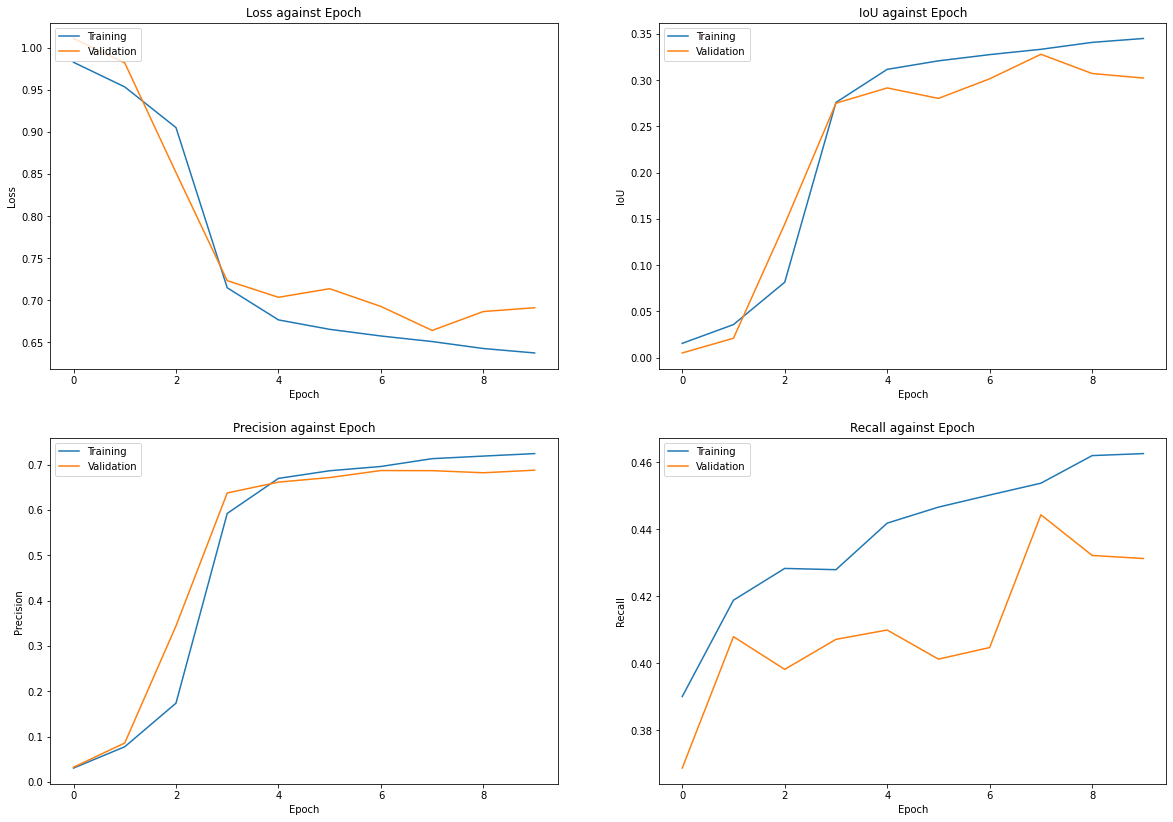

In [13]:
plt.figure(figsize=(20, 14))

# Plot training & validation loss values
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss against Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Plot training & validation iou values
plt.subplot(2, 2, 2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('IoU against Epoch')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision against Epoch')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall against Epoch')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

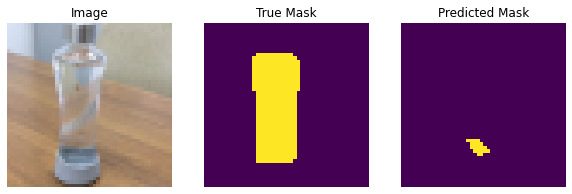

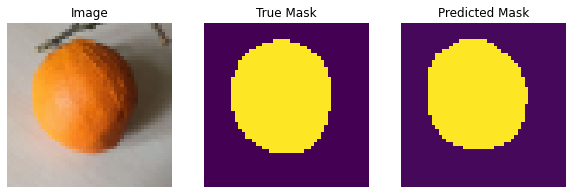

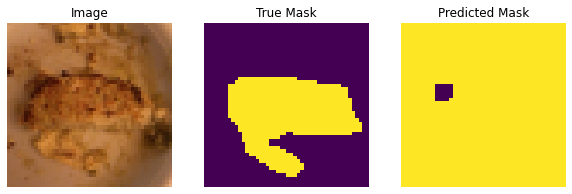

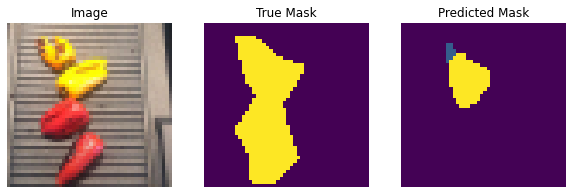

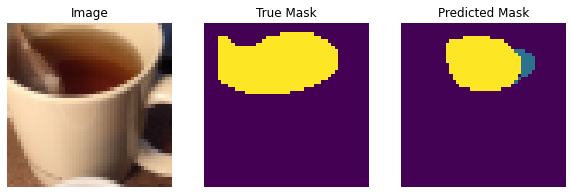

In [14]:
# Visualise samples of the validation dataset and the corresponding predictions
showPredictions(val_gen, model)